<a href="https://colab.research.google.com/github/gvigkannan/covid-cxr/blob/master/Bixia_CohenCOVID_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Author: Vignesh Kannan

In [12]:
from __future__ import print_function, division
import numpy as np
import time
import os 
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import glob
import pandas as pd
import csv
from PIL import Image, ImageOps
import cv2

In [105]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision, torchsummary
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [95]:
## Downloading Torch XRay vision Models
!pip install torchxrayvision
import torchxrayvision as xrv

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## EDA and Preprocessing

In [ ]:
## Loading the dataset
data_dir = "/content/drive/MyDrive/Cohen-Covid-Images/ONLY_COVID-Pneumonia"
data_fnames = os.listdir(data_dir)
annot_fname = "/content/drive/MyDrive/Cohen-Covid-Images/Brixia_COVID_Cohen.csv"
annot_data = pd.read_csv(annot_fname)

In [ ]:
annot_data

,Unnamed: 0,filename,S-A,S-B,S-C,S-D,S-E,S-F,S-Global,J-A,J-B,J-C,J-D,J-E,J-F,J-Global
0,0,6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg,3.0,3.0,3.0,3.0,3.0,3.0,18.0,2.0,3.0,3.0,3.0,3.0,3.0,17.0
1,1,covid-19-pneumonia-12.jpg,2.0,2.0,3.0,2.0,3.0,2.0,14.0,3.0,3.0,3.0,2.0,3.0,3.0,17.0
2,2,covid-19-rapidly-progressive-acute-respiratory...,2.0,3.0,3.0,2.0,3.0,3.0,16.0,2.0,2.0,3.0,2.0,3.0,3.0,15.0
3,3,F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg,3.0,3.0,3.0,2.0,2.0,3.0,16.0,2.0,3.0,3.0,2.0,2.0,2.0,14.0
4,4,31BA3780-2323-493F-8AED-62081B9C383B.jpeg,2.0,3.0,3.0,2.0,3.0,3.0,16.0,2.0,3.0,3.0,1.0,2.0,3.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,nejmoa2001191_f1-PA.jpeg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,61,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,62,1-s2.0-S1684118220300682-main.pdf-002-a1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,63,1-s2.0-S1684118220300682-main.pdf-002-a2.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
brixia_cohen_covid = annot_data.loc[annot_data['filename'].isin(data_fnames)]
# brixia_cohen_covid.to_csv("Brixia_COVID_Cohen.csv")

In [9]:
print(len(data_fnames))
print(data_fnames[0])

65
covid-19-pneumonia-14-PA.png


In [10]:
## Selecting just the Seniority and Junior Scores
brixia_cohen_covid = brixia_cohen_covid[['filename','S-Global', 'J-Global']]
brixia_cohen_covid

,filename,S-Global,J-Global
0,6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg,18.0,17.0
1,covid-19-pneumonia-12.jpg,14.0,17.0
2,covid-19-rapidly-progressive-acute-respiratory...,16.0,15.0
3,F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg,16.0,14.0
4,31BA3780-2323-493F-8AED-62081B9C383B.jpeg,16.0,14.0
...,...,...,...
60,nejmoa2001191_f1-PA.jpeg,0.0,0.0
61,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...,0.0,0.0
62,1-s2.0-S1684118220300682-main.pdf-002-a1.png,0.0,0.0
63,1-s2.0-S1684118220300682-main.pdf-002-a2.png,0.0,0.0


Cell Execution:  0.44959354400634766


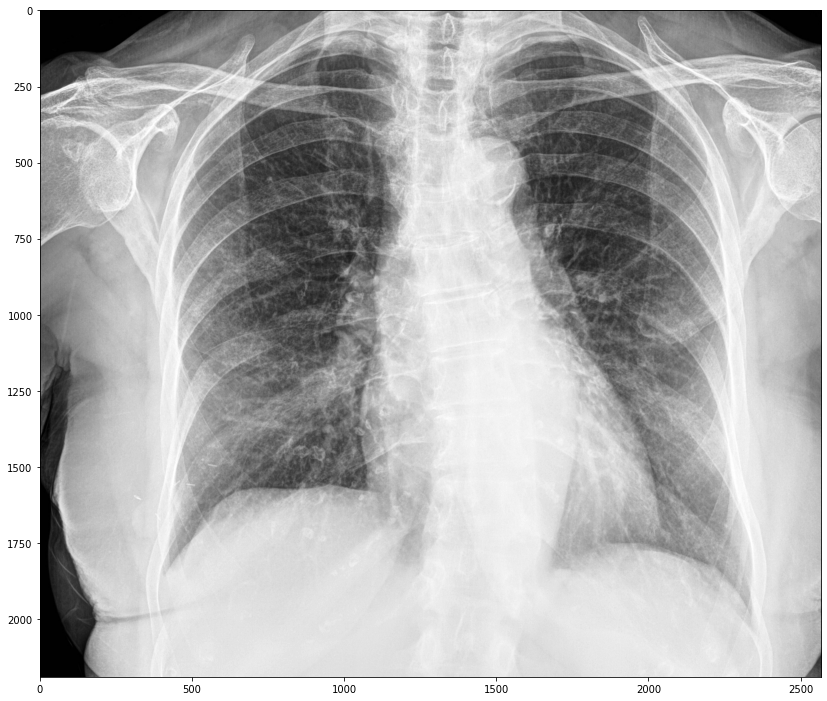

In [29]:
start_cell = time.time()
plt.figure(figsize = (14, 14))
img_pil = ImageOps.grayscale(Image.open(os.path.join(data_dir, data_fnames[0])))
img_cv2 = cv2.imread(os.path.join(data_dir, data_fnames[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(img_pil, cmap = 'gray')
np.shape(img_pil) ## Problem. Models expect a single channel
print("Cell Execution: ", time.time() - start_cell)

In [25]:
data_fnames[0]

'covid-19-pneumonia-14-PA.png'

Cell Execution:  0.1833808422088623


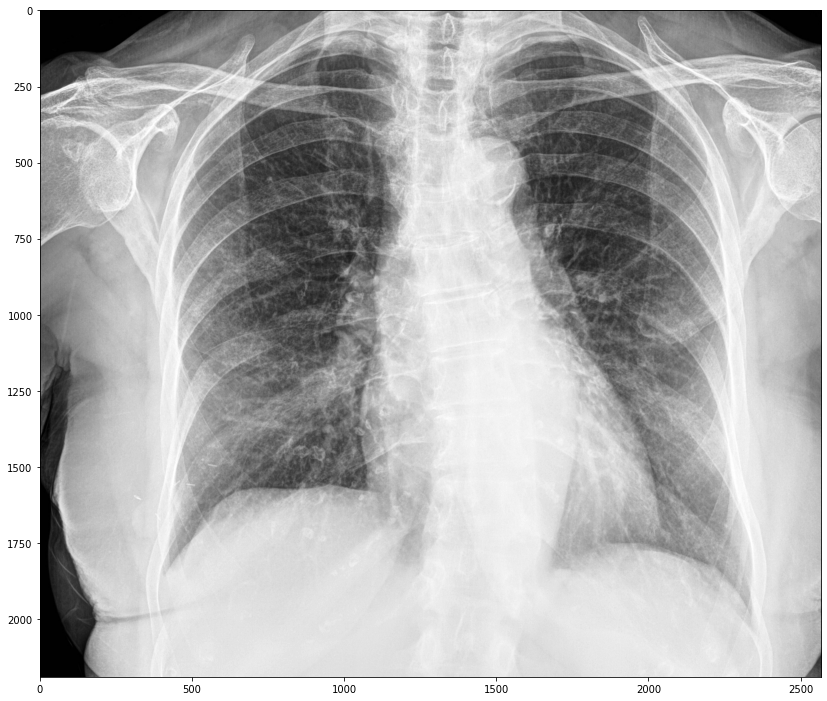

In [28]:
## For the purpose of comparison. Much faster
start_cell = time.time()
data_temp = data_fnames[0]
img_cv2 = cv2.imread(os.path.join(data_dir, data_temp), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize = (14, 14))
plt.imshow(img_cv2, cmap = 'gray')
print("Cell Execution: ", time.time() - start_cell)

In [90]:
# class Brixia_CCOVID_Dataset(Dataset):
#     """ Files for the COVID Cohen Dataset """

#     def __init__(self, data_dir, annot_dir, transform = None):
#         """ Read Images and c """



In [45]:
def load_img(filename, target_size = 224):
  """
  Load and resize the grayscale image.
  :param filename: path/filename
  :param target_size: output shape of image
  :return: loaded images as (width, height, 1)
  """

  img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  if img is None:
    print("File Couldn't be recognized: {}".format(filename))

  img = img / 255.0
  img = cv2.resize(img, (target_size, target_size))
  ## To match Pytorch Requirement
  img = np.reshape(img, (1, ) + img.shape )
  return img

In [46]:
## Testing
path = os.path.join(data_dir, data_temp)
img = load_img(path)
np.shape(img)

(1, 224, 224)

In [99]:
def shuffle_split(X, y, test_ratio = 0.2):
  """
  Shuffle and Split Dataset
  """
  lenData = len(y)
  ind = np.random.permutation(np.arange(lenData))
  X, y = X[ind], y[ind]
  testX, testY = X[:int(lenData*test_ratio)], y[:int(lenData*test_ratio)]
  trainX, trainY = X[int(lenData*test_ratio):], y[int(lenData*test_ratio):]
  return trainX, trainY, testX, testY



In [100]:
def get_data(img_dir, annot_dir, target_size = 224, test_size = 0.1, 
             random_state = 42, preprocessing = True, label = 'both'):
    """
    Get the train and test data from cohen dataset
    Adapted from Brixia Github
    """
    ## Load Annotation:
    annot_data = pd.read_csv(annot_dir)
    X = []
    y = []

    ## For all the images
    for idx in tqdm(annot_data.itertuples()):
      ## Loading Images:
      img = load_img(os.path.join(img_dir, idx.filename), target_size)
      ##To do. Implement Equalize
      y.append([idx[8], idx[15]])
      X.append(img)
    X = np.asarray(X)
    y = np.asarray(y)  
    len_data = len(y)
    # lengths = [int(len_data*(1-test_size)), int(len_data*test_size)]
    trainX, trainY, testX, testY = shuffle_split(X, y, test_ratio = 0.1)
    # dataset = Dataset(X, y)
    # train, test = random_split(dataset, lengths)
    return (trainX, trainY), (testX, testY)
    




In [101]:
## Dataset Hyperparams
batch_size = 8

In [98]:
data_dir = "/content/drive/MyDrive/Cohen-Covid-Images/ONLY_COVID-Pneumonia"
annot_fname = "/content/drive/MyDrive/Cohen-Covid-Images/Brixia_COVID_Cohen.csv"

trainX, trainY, testX, testY = get_data(img_dir = data_dir, annot_dir = annot_fname, preprocessing = False )


65
[26 40 57 56  3 31 36 14  1 48  7 19 22 49 20 43  2 62 29 17 61 55 13  0
  9 50 47 45 33 38 35 25 21  5 54 32 16  4 46 59 34 30 12 52 60 15 18  8
 37 23 63 64 39 42 53 44 24 41 11 27 51 58 10 28  6]


In [103]:
train_dataset = TensorDataset(torch.tensor(trainX), torch.tensor(trainY))
test_dataset = TensorDataset(torch.tensor(testX), torch.tensor(testY))
train_dl = DataLoader(train_dataset, batch_size, shuffle = True)
test_dl = DataLoader(test_dataset, batch_size*2, shuffle = False)

In [93]:
## Creating an Instance of DataLoader!
# train_dl = DataLoader(train_dataset, batch_size = 8, shuffle = True)
# X, y = next(iter(train_dl))
# print(np.shape(X))
# print(np.shape(y))

torch.Size([8, 1, 224, 224])
torch.Size([8, 2])


In [70]:
## Trial!
# for idx in tqdm(annot_data.itertuples()):
#   print(idx.filename)
#   print(idx[8])
#   break

6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg
3.0


## Model Related

In [146]:
model_clf2 = xrv.models.DenseNet(weights = 'all')
for param in model_clf2.parameters():
  param.requires_grad = False
model_clf2.op_threshs = None

In [147]:
torchsummary.summary(model_clf2, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

In [148]:
model_clf2.classifier = nn.Linear(in_features = 1024,
                                  out_features = 2)

In [149]:
torchsummary.summary(model_clf2, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_temp)

In [ ]:
## Model Hyperparams:
numEpochs = 1

In [ ]:
train_loss_hist, test_loss_hist = [],  []
for epoch in tqdm(range(numEpochs))